In [1]:
import sys, os, time, datetime, csv
sys.path.insert(1, '/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/tools')
from tools import *
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm
from matplotlib.lines import Line2D

import trackml.dataset

import pandas as pd

from mpl_toolkits import mplot3d



In [2]:
def plot_cartesian(filenames,n_section,n_files):
        fig, ax = plt.subplots(1,2,figsize = (10,5),sharey=True, tight_layout=True)
        cmap = plt.get_cmap('bwr_r')
        theta_counter = 0 # start 45 degree rotated
        total_false_edges = 0
        total_true_edges = 0
        for i in range(n_files):
            print('Plotting file: ' + filenames[i])
            X, Ri, Ro, y = load_graph(filenames[i])
            #print('Zmin: %.2f, Zmax: %.2f' %(min(X[:,2]),max(X[:,2]))   )
            X[:,1] = X[:,1] * np.pi/n_section
            theta = (X[:,1] + theta_counter)%(np.pi*2)
           
            ax[0].scatter(1000*X[:,0]*np.cos(theta), 1000*X[:,0]*np.sin(theta), c='k', s=3)
            ax[1].scatter(1000*X[:,0]*np.cos(theta), 1000*X[:,0]*np.sin(theta), c='k', s=3)

            #ax1.scatter(1000*X[:,0]*np.cos(theta), 1000*X[:,2], c='k')

            feats_o = X[np.where(Ri.T)[1]]
            feats_i = X[np.where(Ro.T)[1]]

            x_o = 1000*feats_o[:,0]*np.cos(feats_o[:,1]+theta_counter)
            x_i = 1000*feats_i[:,0]*np.cos(feats_i[:,1]+theta_counter)
            y_o = 1000*feats_o[:,0]*np.sin(feats_o[:,1]+theta_counter)
            y_i = 1000*feats_i[:,0]*np.sin(feats_i[:,1]+theta_counter)

            # print only false edges
            for j in range(y.shape[0]):
                seg_args = dict(c='darkblue', alpha=1-y[j])
                ax[0].plot([x_o[j],x_i[j]],[y_o[j],y_i[j]], '-', **seg_args)

            
            # print only true edges
            for j in range(y.shape[0]):
                seg_args = dict(c='darkblue', alpha=y[j])
                ax[1].plot([x_o[j],x_i[j]],[y_o[j],y_i[j]], '-', **seg_args)

            # draw seperator line
            ax[0].plot([0,1100*np.cos(theta_counter-np.pi/n_section)],[0,1100*np.sin(theta_counter-np.pi/n_section)],'-', c='darkorange')
            ax[0].plot([0,1100*np.cos(theta_counter+np.pi/n_section)],[0,1100*np.sin(theta_counter+np.pi/n_section)],'-', c='darkorange')
            ax[1].plot([0,1100*np.cos(theta_counter-np.pi/n_section)],[0,1100*np.sin(theta_counter-np.pi/n_section)],'-', c='darkorange')
            ax[1].plot([0,1100*np.cos(theta_counter+np.pi/n_section)],[0,1100*np.sin(theta_counter+np.pi/n_section)],'-', c='darkorange')

            total_true_edges  += sum(y)
            total_false_edges += y.shape[0] - sum(y)

            theta_counter += 2*np.pi/n_section
            theta_counter = theta_counter%(np.pi*2)

        print('Plotting a graph with %d true, %d false, %d total edges'%(total_true_edges,total_false_edges,total_false_edges+total_true_edges))

        ax[0].set_xlabel('x [mm]')
        ax[0].set_ylabel('y [mm]')
        ax[1].set_xlabel('$x [mm]$')
        ax[1].set_ylabel('$y [mm]$')
        ax[0].set_aspect('equal')
        ax[1].set_aspect('equal')
        ax[0].set_title('Only Fake Edges (After Preprocessing)')
        ax[1].set_title('Only True Edges (After Preprocessing)')
       
        plt.show()

In [3]:
def plot_3d(filenames,n_section,n_files, make_gif=False):

    def change_view(az=20):
        ax.view_init(elev=10, azim=az%360)
        return ax 

    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    cmap = plt.get_cmap('bwr_r')
    theta_counter = np.pi/n_section # start 45 degree rotated
    for i in range(n_files):
        print('Plotting file: ' + filenames[i])
        X, Ri, Ro, y = load_graph(filenames[i])
        X[:,1] = X[:,1] * np.pi/n_section
        theta = (X[:,1] + theta_counter)%(np.pi*2)
           
        ax.scatter(1000*X[:,2],1000*X[:,0]*np.cos(theta), 1000*X[:,0]*np.sin(theta), c='k',s=1)

        feats_o = X[np.where(Ri.T)[1]]
        feats_i = X[np.where(Ro.T)[1]]

        x_o = 1000*feats_o[:,0]*np.cos(feats_o[:,1]+theta_counter)
        x_i = 1000*feats_i[:,0]*np.cos(feats_i[:,1]+theta_counter)
        y_o = 1000*feats_o[:,0]*np.sin(feats_o[:,1]+theta_counter)
        y_i = 1000*feats_i[:,0]*np.sin(feats_i[:,1]+theta_counter)
        z_o = 1000*feats_o[:,2]
        z_i = 1000*feats_i[:,2]
        
        for j in range(y.shape[0]):
            seg_args = dict(c='C'+str(i), alpha=float(y[j]))
            ax.plot([z_o[j],z_i[j]],[x_o[j],x_i[j]],[y_o[j],y_i[j]],'-', **seg_args)
        
        if i%2==1:
            theta_counter += 2*np.pi/n_section
            theta_counter = theta_counter%(np.pi*2)
        
    ax.set_xlabel('$Z [mm]$')
    ax.set_ylabel('$X [mm]$')  
    ax.set_zlabel('$Y [mm]$') 
    ax.grid(b=None)
    change_view(45)
    ax.dist = 8 
   

In [4]:
cols = [ 'edge', 'label', 'eta', 'phi', 'true_pt', 'layer', 'track_length', 'hit1_id', 'hit2_id', 'particle_num'] #suggested column names
event = pd.DataFrame(np.load('/Users/lucascurtin/Desktop/event_1000/edges_preprocessed_000001000 (1).npy',allow_pickle = True), columns = cols)

In [5]:
true_events=event.loc[event['label'] == 1]

fake_events=event.loc[event['label'] == 0]


Despite me not being to exactly execute Marcin's code, I've found that his number of edges aligns with Tuysuz's one nearly perfectly (off by 3 which could be explained by edge cases possibly?) This means the error lies with how I'm splitting up the code most likely. 

## Plot Reconstruction

So we want to do is to get the edge, get the x y coordinates of each input and output node, plot them with a line between them

In [6]:
x_input=[]
y_input=[]

x_output=[]
y_output=[]

for i in range(len(fake_events)):
    r_i,theta_i,z_i=fake_events['edge'].iloc[i][0:3]
    r_o,theta_o,z_o=fake_events['edge'].iloc[i][3:6]

    x_i=r_i*np.cos(theta_i)
    y_i=r_i*np.sin(theta_i)
    x_input.append(x_i)
    y_input.append(y_i)


    x_o=r_o*np.cos(theta_o)
    y_o=r_o*np.sin(theta_o)
    x_output.append(x_o)
    y_output.append(y_o)



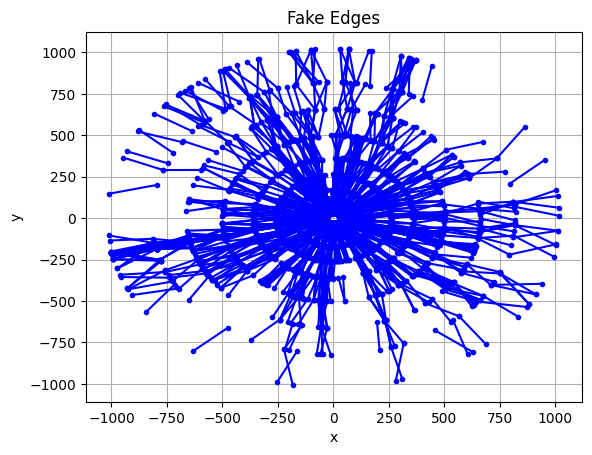

In [7]:
#plt.scatter(x_input, y_input,label='input')
#plt.scatter(x_output,y_output, label='output')
plt.grid()


for i in range(len(x_input)):
    plt.plot([x_input[i],x_output[i]],[y_input[i],y_output[i]],'b.-')


plt.title('Fake Edges')
plt.ylabel("y")
plt.xlabel("x")

plt.show()

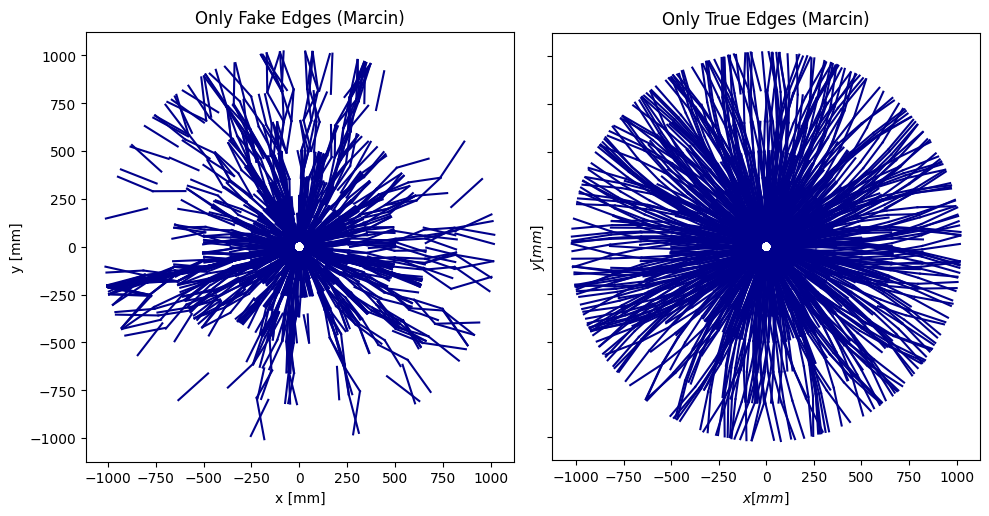

In [7]:
fig, ax = plt.subplots(1,2,figsize = (10,5),sharey=True, tight_layout=True)
cmap = plt.get_cmap('bwr_r')
theta_counter = 0 # start 45 degree rotated
total_false_edges = 0
total_true_edges = 0



x_input=[]
y_input=[]

x_output=[]
y_output=[]


#fake events

for i in range(len(fake_events)):
    r_i,theta_i,z_i=fake_events['edge'].iloc[i][0:3]
    r_o,theta_o,z_o=fake_events['edge'].iloc[i][3:6]

    x_i=r_i*np.cos(theta_i)
    y_i=r_i*np.sin(theta_i)
    x_input.append(x_i)
    y_input.append(y_i)


    x_o=r_o*np.cos(theta_o)
    y_o=r_o*np.sin(theta_o)
    x_output.append(x_o)
    y_output.append(y_o)


#I've update the seg argument lines, not it was erroneusly removing some edges (I think they use it so for each graph they plot the edges and if it has the wrong
#y label for the plot at hand then you can't see it!)

# print only false edges
for j in range(len(fake_events)):
    #seg_args = dict(c='darkblue', alpha=1-y[j])
    seg_args = dict(c='darkblue')
    ax[0].plot([x_output[j],x_input[j]],[y_output[j],y_input[j]], '-', **seg_args)




#true events
x_input=[]
y_input=[]

x_output=[]
y_output=[]

for i in range(len(true_events)):
    r_i,theta_i,z_i=true_events['edge'].iloc[i][0:3]
    r_o,theta_o,z_o=true_events['edge'].iloc[i][3:6]

    x_i=r_i*np.cos(theta_i)
    y_i=r_i*np.sin(theta_i)
    x_input.append(x_i)
    y_input.append(y_i)


    x_o=r_o*np.cos(theta_o)
    y_o=r_o*np.sin(theta_o)
    x_output.append(x_o)
    y_output.append(y_o)



# print only true edges
for j in range(len(true_events)):
    #seg_args = dict(c='darkblue', alpha=y[j])
    seg_args = dict(c='darkblue')
    ax[1].plot([x_output[j],x_input[j]],[y_output[j],y_input[j]], '-', **seg_args)

ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[1].set_xlabel('$x [mm]$')
ax[1].set_ylabel('$y [mm]$')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_title('Only Fake Edges (Marcin)')
ax[1].set_title('Only True Edges (Marcin)')

plt.show()

In [9]:
print('Number of Fake events',len(fake_events))
print('Number of True events',len(true_events))

Number of Fake events 5511
Number of True events 5162


My data:
Plotting file: /Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/data_personal/tuysuz_original/train/event000001000_g000.npz
Plotting a graph with 5162 true, 5508 false, 10670 total edges


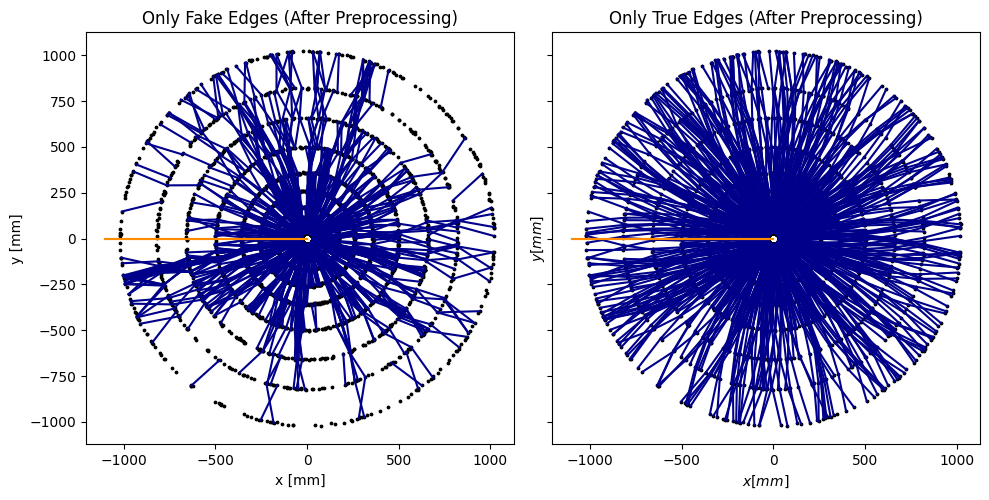

In [10]:
input_dir=r'/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/data_personal/tuysuz_original/train'
n_section = 1
n_files = 1

    
   
input_dir = os.path.expandvars(input_dir)
filenames = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) 
            if f.startswith('event') and f.endswith('.npz')])
filenames[:n_files] if n_files is not None else filenames


print('My data:')
plot_cartesian(filenames,n_section,n_files)



In [37]:
X[:,0]

array([0.03144621, 0.07216   , 0.11557334, ..., 0.65818244, 0.81695163,
       1.0168136 ], dtype=float32)

# 3D Comparison

# Going to see if we can get the original Tuysuz Data into a Pandas DF

In [19]:


theta_counter = np.pi/n_section # start 45 degree rotated

X, Ri, Ro, y = load_graph('/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/data_personal/tuysuz_original/train/event000001000_g000.npz')
X[:,1] = X[:,1] * np.pi/n_section
theta = (X[:,1] + theta_counter)%(np.pi*2)
    


feats_o = X[np.where(Ri.T)[1]]
feats_i = X[np.where(Ro.T)[1]]

x_o = 1000*feats_o[:,0]*np.cos(feats_o[:,1]+theta_counter)
x_i = 1000*feats_i[:,0]*np.cos(feats_i[:,1]+theta_counter)
y_o = 1000*feats_o[:,0]*np.sin(feats_o[:,1]+theta_counter)
y_i = 1000*feats_i[:,0]*np.sin(feats_i[:,1]+theta_counter)
z_o = 1000*feats_o[:,2]
z_i = 1000*feats_i[:,2]
    


In [26]:

#tuysuz_df = pd.DataFrame(tuysuz_array, columns = ['x_o','x_i','y_o','y_i','z_o','z_i'])


tuysuz_df = pd.DataFrame({'x_input': x_i,
                   'x_output': x_o,
                   'y_input': y_i,
                   'y_output': y_o,
                   'z_input': z_i,
                   'z_output': z_o,
                   'label':y
                   
                   
                   
                   
                   })

In [14]:
#true events
x_input=[]
y_input=[]
z_input=[]

x_output=[]
y_output=[]
z_output=[]
label=[]

for i in range(len(event)):
    r_initial,theta_i,z_initial=event['edge'].iloc[i][0:3]
    r_outputf,theta_o,z_outputf=event['edge'].iloc[i][3:6]
    y_val=event['label'].iloc[i]

    x_initial=r_initial*np.cos(theta_i)
    y_initial=r_initial*np.sin(theta_i)
    x_input.append(x_initial)
    y_input.append(y_initial)
    z_input.append(z_initial)


    x_outputf=r_outputf*np.cos(theta_o)
    y_outputf=r_outputf*np.sin(theta_o)
    x_output.append(x_outputf)
    y_output.append(y_outputf)
    z_output.append(z_outputf)
    label.append(y_val)

In [15]:
marcin_df = pd.DataFrame({'x_input': x_input,
                   'x_output': x_output,
                   'y_input': y_input,
                   'y_output': y_output,
                   'z_input': z_input,
                   'z_output': z_output,
                   'label':label
                   
                   
                   
                   
                   })

In [17]:
def df_limiter(df,x_limit,y_limit,z_limit,z_limiter,label):


    if label==2:

        if z_limiter==1:
            df_limited= df.loc[((df['x_input'] > x_limit) & (df['x_output'] > x_limit) & (df['y_input'] > y_limit) & (df['y_output'] > y_limit) & 
                (df['z_input'] > 0) & (df['z_output'] > 0))]

        if z_limiter==0:

            df_limited= df.loc[((df['x_input'] > x_limit) & (df['x_output'] > x_limit) & (df['y_input'] > y_limit) & (df['y_output'] > y_limit) & 
                (df['z_input'] > z_limit) & (df['z_output'] > z_limit))]

    if label==1:

        if z_limiter==1:
            df_limited= df.loc[((df['x_input'] > x_limit) & (df['x_output'] > x_limit) & (df['y_input'] > y_limit) & (df['y_output'] > y_limit) & 
            (df['z_input'] > 0) & (df['z_output'] > 0) & (df['label'] > 0.5))]

        if z_limiter==0:

            df_limited= df.loc[((df['x_input'] > x_limit) & (df['x_output'] > x_limit) & (df['y_input'] > y_limit) & (df['y_output'] > y_limit) & 
            (df['z_input'] > z_limit) & (df['z_output'] > z_limit)& (df['label'] > 0.5))]
            
    if label==0:

        if z_limiter==1:
            df_limited= df.loc[((df['x_input'] > x_limit) & (df['x_output'] > x_limit) & (df['y_input'] > y_limit) & (df['y_output'] > y_limit) & 
            (df['z_input'] > 0) & (df['z_output'] > 0) & (df['label'] < 0.5))]

        if z_limiter==0:

            df_limited= df.loc[((df['x_input'] > x_limit) & (df['x_output'] > x_limit) & (df['y_input'] > y_limit) & (df['y_output'] > y_limit) & 
            (df['z_input'] > z_limit) & (df['z_output'] > z_limit)& (df['label'] < 0.5))]


    return df_limited

In [18]:
x_limit=500
y_limit=500
z_limit=0


tuysuz_limited=tuysuz_df_limiter(x_limit,y_limit,z_limit,0)

fig = plt.figure()
ax = plt.axes(projection='3d')

x_input_points=np.array(tuysuz_limited['x_i'])
y_input_points=np.array(tuysuz_limited['y_i'])
z_input_points=np.array(tuysuz_limited['z_i'])

x_output_points=np.array(tuysuz_limited['x_o'])
y_output_points=np.array(tuysuz_limited['y_o'])
z_output_points=np.array(tuysuz_limited['z_o'])

for i in range(len(x_input_points)):

    ax.plot([x_output_points[i],x_input_points[i]],[y_output_points[i],y_input_points[i]],[z_output_points[i],z_input_points[i]], '-', **seg_args)


ax.scatter3D( x_input_points, y_input_points , z_input_points, cmap='Greens')
ax.scatter3D( x_output_points, y_output_points , z_output_points, cmap='Oranges')

ax.set_title("Tuysuz Data, Limit={}".format(limit))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

TypeError: tuysuz_df_limiter() missing 1 required positional argument: 'label'

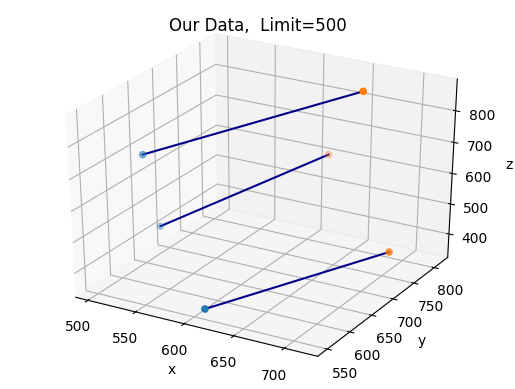

In [ ]:
x_limit=500
y_limit=500
z_limit=0
z_limiter=0
label=2


marcin_limited=marcin_df_limiter(x_limit,y_limit,z_limit,z_limiter,label)



fig = plt.figure()
ax = plt.axes(projection='3d')

x_input_points=np.array(marcin_limited['x_input'])
y_input_points=np.array(marcin_limited['y_input'])
z_input_points=np.array(marcin_limited['z_input'])

x_output_points=np.array(marcin_limited['x_output'])
y_output_points=np.array(marcin_limited['y_output'])
z_output_points=np.array(marcin_limited['z_output'])



for i in range(len(x_input_points)):

    ax.plot([x_output_points[i],x_input_points[i]],[y_output_points[i],y_input_points[i]],[z_output_points[i],z_input_points[i]], '-', **seg_args)


ax.scatter3D( x_input_points, y_input_points , z_input_points, cmap='Greens')
ax.scatter3D( x_output_points, y_output_points , z_output_points, cmap='Oranges')


ax.set_title("Our Data,  Limit={}".format(x_limit))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [ ]:
x_limit=0
y_limit=0
z_limit=0
z_limiter=0
label=0


tuysuz_limited=df_limiter(tuysuz_df,x_limit,y_limit,z_limit,z_limiter,label)




marcin_limited=df_limiter(marcin_df,x_limit,y_limit,z_limit,z_limiter,label)

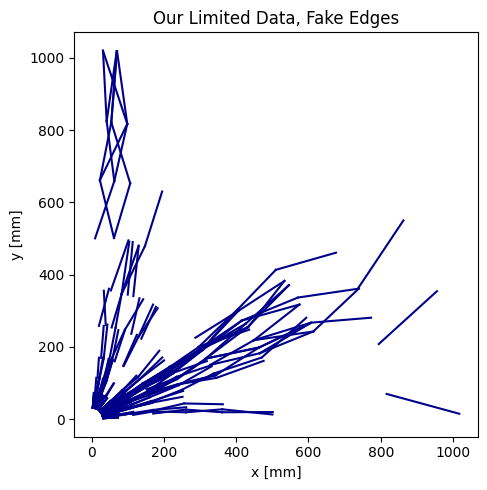

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (10,5),sharey=True, tight_layout=True)
cmap = plt.get_cmap('bwr_r')
theta_counter = 0 # start 45 degree rotated
total_false_edges = 0
total_true_edges = 0


x_input=np.array(marcin_limited['x_input'])
y_input=np.array(marcin_limited['y_input'])

x_output=np.array(marcin_limited['x_output'])
y_output=np.array(marcin_limited['y_output'])




# print only true edges
for j in range(len(marcin_limited)):
    #seg_args = dict(c='darkblue', alpha=y[j])
    seg_args = dict(c='darkblue')
    ax.plot([x_output[j],x_input[j]],[y_output[j],y_input[j]], '-', **seg_args)

ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

ax.set_aspect('equal')

ax.set_title('Our Limited Data, Fake Edges')


plt.show()

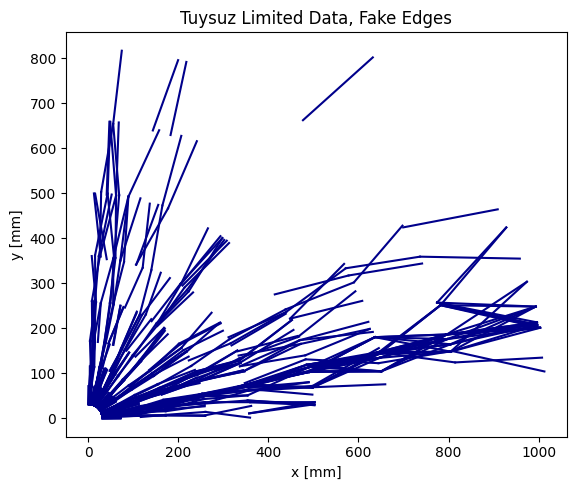

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (10,5),sharey=True, tight_layout=True)
cmap = plt.get_cmap('bwr_r')
theta_counter = 0 # start 45 degree rotated
total_false_edges = 0
total_true_edges = 0


x_input=np.array(tuysuz_limited['x_input'])
y_input=np.array(tuysuz_limited['y_input'])

x_output=np.array(tuysuz_limited['x_output'])
y_output=np.array(tuysuz_limited['y_output'])




# print only true edges
for j in range(len(tuysuz_limited)):
    #seg_args = dict(c='darkblue', alpha=y[j])
    seg_args = dict(c='darkblue')
    ax.plot([x_output[j],x_input[j]],[y_output[j],y_input[j]], '-', **seg_args)

ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

ax.set_aspect('equal')

ax.set_title('Tuysuz Limited Data, Fake Edges')


plt.show()

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (10,5),sharey=True, tight_layout=True)
cmap = plt.get_cmap('bwr_r')
theta_counter = 0 # start 45 degree rotated
total_false_edges = 0
total_true_edges = 0



x_input=[]
y_input=[]

x_output=[]
y_output=[]


#fake events

for i in range(len(fake_events)):
    r_i,theta_i,z_i=fake_events['edge'].iloc[i][0:3]
    r_o,theta_o,z_o=fake_events['edge'].iloc[i][3:6]

    x_i=r_i*np.cos(theta_i)
    y_i=r_i*np.sin(theta_i)
    x_input.append(x_i)
    y_input.append(y_i)


    x_o=r_o*np.cos(theta_o)
    y_o=r_o*np.sin(theta_o)
    x_output.append(x_o)
    y_output.append(y_o)


#I've update the seg argument lines, not it was erroneusly removing some edges (I think they use it so for each graph they plot the edges and if it has the wrong
#y label for the plot at hand then you can't see it!)

# print only false edges
for j in range(len(fake_events)):
    #seg_args = dict(c='darkblue', alpha=1-y[j])
    seg_args = dict(c='darkblue')
    ax[0].plot([x_output[j],x_input[j]],[y_output[j],y_input[j]], '-', **seg_args)




#true events
x_input=[]
y_input=[]

x_output=[]
y_output=[]

for i in range(len(true_events)):
    r_i,theta_i,z_i=true_events['edge'].iloc[i][0:3]
    r_o,theta_o,z_o=true_events['edge'].iloc[i][3:6]

    x_i=r_i*np.cos(theta_i)
    y_i=r_i*np.sin(theta_i)
    x_input.append(x_i)
    y_input.append(y_i)


    x_o=r_o*np.cos(theta_o)
    y_o=r_o*np.sin(theta_o)
    x_output.append(x_o)
    y_output.append(y_o)



# print only true edges
for j in range(len(true_events)):
    #seg_args = dict(c='darkblue', alpha=y[j])
    seg_args = dict(c='darkblue')
    ax[1].plot([x_output[j],x_input[j]],[y_output[j],y_input[j]], '-', **seg_args)

ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[1].set_xlabel('$x [mm]$')
ax[1].set_ylabel('$y [mm]$')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_title('Only Fake Edges (Marcin)')
ax[1].set_title('Only True Edges (Marcin)')

plt.show()

,x_input,x_output,y_input,y_output,z_input,z_output,label
10293,611.783997,716.943970,548.612976,724.461975,357.600006,439.000000,1
10319,502.784027,662.463013,644.671021,782.031067,683.200012,861.799988,1
10530,528.958984,614.991028,625.408997,814.489075,488.000000,601.799988,1


# Reverse Engineering

In [178]:
theta_counter = np.pi/n_section # start 45 degree rotated

X, Ri, Ro, y = load_graph('/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/data_personal/tuysuz_original/train/event000001000_g000.npz')
X[:,1] = X[:,1] * np.pi/n_section
theta = (X[:,1] + theta_counter)%(np.pi*2)
    


feats_o = X[np.where(Ri.T)[1]]
feats_i = X[np.where(Ro.T)[1]]

x_o = 1000*feats_o[:,0]*np.cos(feats_o[:,1]+theta_counter)
x_i = 1000*feats_i[:,0]*np.cos(feats_i[:,1]+theta_counter)
y_o = 1000*feats_o[:,0]*np.sin(feats_o[:,1]+theta_counter)
y_i = 1000*feats_i[:,0]*np.sin(feats_i[:,1]+theta_counter)
z_o = 1000*feats_o[:,2]
z_i = 1000*feats_i[:,2]
    


In [188]:
qq=np.zeros([3,2])
qq

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [187]:
np.shape(qq)

(3, 2)

In [183]:
np.shape(Ri)

(6437, 10670)

In [179]:
feats_o

array([[ 0.07216   ,  2.6598682 ,  0.136875  ],
       [ 0.07173023,  2.6526859 ,  0.0512155 ],
       [ 0.07209888,  2.6664708 ,  0.101208  ],
       ...,
       [ 1.0182625 , -1.2421858 ,  0.87259996],
       [ 1.0204347 ,  0.23941793, -0.0976    ],
       [ 1.0168136 ,  2.5308046 ,  0.0976    ]], dtype=float32)

In [180]:
feats_i

array([[ 0.03144621,  2.6717088 ,  0.0595952 ],
       [ 0.03144621,  2.6717088 ,  0.0595952 ],
       [ 0.03144621,  2.6717088 ,  0.0595952 ],
       ...,
       [ 0.82092136, -1.2120618 ,  0.7048    ],
       [ 0.81638956,  0.21741717, -0.076     ],
       [ 0.81695163,  2.4739885 ,  0.076     ]], dtype=float32)

In [138]:
np.shape(X)

(6437, 3)

In [108]:
X[1488]

array([0.07173023, 2.6526859 , 0.0512155 ], dtype=float32)

In [156]:
np.where(Ri.T)

(10670, 6437)

In [169]:
Ri[163].T.tolist().count(1)

5

In [137]:
event['edge']

0        [31.496714, -1.2947888, 44.7477, 72.56859, -1....
1        [31.496714, -1.2947888, 44.7477, 72.45377, -1....
2        [31.496714, -1.2947888, 44.7477, 72.3823, -1.2...
3        [31.496714, -1.2947888, 44.7477, 71.79107, -1....
4        [31.935396, -2.7976387, -24.3397, 71.77119, -2...
                               ...                        
10668    [820.3942, -1.5300422, 151.6, 1023.5756, -1.49...
10669    [817.7667, -0.81763387, -130.0, 1021.2284, -0....
10670    [819.30994, -0.9875191, -623.4, 1022.1961, -1....
10671    [820.3252, -1.8162135, 179.0, 1019.38654, -1.7...
10672    [818.0706, -0.8674522, 694.0, 1023.43524, -0.8...
Name: edge, Length: 10673, dtype: object

In [80]:
X = (hits[feature_names].values / feature_scale).astype(np.float32)
Ri = np.zeros((n_hits, n_edges), dtype=np.uint8)
Ro = np.zeros((n_hits, n_edges), dtype=np.uint8)
y = np.zeros(n_edges, dtype=np.float32)


array([ 0.88619745,  0.8828469 ,  0.889237  , ..., -0.32272825,
       -0.97147614,  0.8191965 ], dtype=float32)

In [81]:
np.array([1000., np.pi / 1, 1000.])

array([1000.        ,    3.14159265, 1000.        ])

In [74]:
1000*feats_o[:,0]

array([  72.159996,   71.730225,   72.098885, ..., 1018.2625  ,
       1020.43475 , 1016.81366 ], dtype=float32)

In [177]:
Ri.T[0]

array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)

In [85]:
X

array([[0.03144621, 2.6717088 , 0.0595952 ],
       [0.07216   , 2.6598682 , 0.136875  ],
       [0.11557334, 2.64851   , 0.21927   ],
       ...,
       [0.65818244, 2.4299638 , 0.0616    ],
       [0.81695163, 2.4739885 , 0.076     ],
       [1.0168136 , 2.5308046 , 0.0976    ]], dtype=float32)

In [54]:
event

,edge,label,eta,phi,true_pt,layer,track_length,hit1_id,hit2_id,particle_num
0,"[31.496714, -1.2947888, 44.7477, 72.56859, -1....",1,1.11799,"[-1.2947888, -1.3045837]","[1.4319831132888794, 1.4319831132888794]",82,"[7, 7]",00000100010017,00000100010017,1095
1,"[31.496714, -1.2947888, 44.7477, 72.45377, -1....",0,-1.049843,"[-1.2947888, -1.2949874]","[1.4319831132888794, 1.157448649406433]",82,"[7, 9]",00000100010017,0000010003481,1095
2,"[31.496714, -1.2947888, 44.7477, 72.3823, -1.2...",0,1.095215,"[-1.2947888, -1.2886992]","[1.4319831132888794, 1.5366206169128418]",82,"[7, 8]",00000100010017,0000010004332,1095
3,"[31.496714, -1.2947888, 44.7477, 71.79107, -1....",0,2.065377,"[-1.2947888, -1.2802732]","[1.4319831132888794, 1.389689326286316]",82,"[7, 6]",00000100010017,0000010004753,1095
4,"[31.935396, -2.7976387, -24.3397, 71.77119, -2...",1,-0.745732,"[-2.7976387, -2.7868211]","[1.1499686241149902, 1.1499686241149902]",82,"[7, 7]",00000100010026,00000100010026,1095
...,...,...,...,...,...,...,...,...,...,...
10668,"[820.3942, -1.5300422, 151.6, 1023.5756, -1.49...",1,0.186919,"[-1.5300422, -1.4959512]","[1.8084810972213745, 1.8084810972213745]",172,"[10, 10]",0000010009880,0000010009880,1095
10669,"[817.7667, -0.81763387, -130.0, 1021.2284, -0....",1,-0.134265,"[-0.81763387, -0.8491727]","[1.973840594291687, 1.973840594291687]",172,"[10, 10]",0000010009881,0000010009881,1095
10670,"[819.30994, -0.9875191, -623.4, 1022.1961, -1....",1,-0.692498,"[-0.9875191, -1.049645]","[1.0365803241729736, 1.0365803241729736]",172,"[9, 9]",0000010009927,0000010009927,1095
10671,"[820.3252, -1.8162135, 179.0, 1019.38654, -1.7...",1,0.21535,"[-1.8162135, -1.7712139]","[1.3330026865005493, 1.3330026865005493]",172,"[5, 5]",0000010009929,0000010009929,1095


In [189]:
def select_segments(hits1, hits2, phi_slope_max, z0_max):
    """
    Construct a list of selected segments from the pairings
    between hits1 and hits2, filtered with the specified
    phi slope and z0 criteria.
    Returns: pd DataFrame of (index_1, index_2), corresponding to the
    DataFrame hit label-indices in hits1 and hits2, respectively.
    """
    # Start with all possible pairs of hits
    keys = ['evtid', 'r', 'phi', 'z']
    hit_pairs = hits1[keys].reset_index().merge(
        hits2[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))
    # Compute line through the points
    dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
    dz = hit_pairs.z_2 - hit_pairs.z_1
    dr = hit_pairs.r_2 - hit_pairs.r_1
    phi_slope = dphi / dr
    z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
    # Filter segments according to criteria
    good_seg_mask = (phi_slope.abs() < phi_slope_max) & (z0.abs() < z0_max)
    return hit_pairs[['index_1', 'index_2']][good_seg_mask]


def construct_graph(hits, layer_pairs,
                    phi_slope_max, z0_max,
                    feature_names, feature_scale):
    """Construct one graph (e.g. from one event)"""

    # Loop over layer pairs and construct segments
    layer_groups = hits.groupby('layer')
    segments = []
    for (layer1, layer2) in layer_pairs:
        # Find and join all hit pairs
        try:
            hits1 = layer_groups.get_group(layer1)
            hits2 = layer_groups.get_group(layer2)
        # If an event has no hits on a layer, we get a KeyError.
        # In that case we just skip to the next layer pair
        except KeyError as e:
            logging.info('skipping empty layer: %s' % e)
            continue
        # Construct the segments
        segments.append(select_segments(hits1, hits2, phi_slope_max, z0_max))
    # Combine segments from all layer pairs
    segments = pd.concat(segments)

    # Prepare the graph matrices
    n_hits = hits.shape[0]
    n_edges = segments.shape[0]
    X = (hits[feature_names].values / feature_scale).astype(np.float32)
    Ri = np.zeros((n_hits, n_edges), dtype=np.uint8)
    Ro = np.zeros((n_hits, n_edges), dtype=np.uint8)
    y = np.zeros(n_edges, dtype=np.float32)

    # We have the segments' hits given by dataframe label,
    # so we need to translate into positional indices.
    # Use a series to map hit label-index onto positional-index.
    hit_idx = pd.Series(np.arange(n_hits), index=hits.index)
    seg_start = hit_idx.loc[segments.index_1].values
    seg_end = hit_idx.loc[segments.index_2].values

    # Now we can fill the association matrices.
    # Note that Ri maps hits onto their incoming edges,
    # which are actually segment endings.
    Ri[seg_end, np.arange(n_edges)] = 1
    Ro[seg_start, np.arange(n_edges)] = 1
    # Fill the segment labels
    pid1 = hits.particle_id.loc[segments.index_1].values
    pid2 = hits.particle_id.loc[segments.index_2].values
    y[:] = (pid1 == pid2)
    # Return a tuple of the results
    return Graph(X, Ri, Ro, y)


def process_event(prefix, output_dir, pt_min, n_eta_sections, n_phi_sections,
                  eta_range, phi_range, phi_slope_max, z0_max):
    # Load the data
    evtid = int(prefix[-9:])
    logging.info('Event %i, loading data' % evtid)
    hits, particles, truth = trackml.dataset.load_event(
        prefix, parts=['hits', 'particles', 'truth'])

    # Apply hit selection
    logging.info('Event %i, selecting hits' % evtid)
    hits = select_hits(hits, truth, particles, pt_min=pt_min).assign(evtid=evtid)

    # Divide detector into sections
    #phi_range = (-np.pi, np.pi)
    phi_edges = np.linspace(*phi_range, num=n_phi_sections+1)
    eta_edges = np.linspace(*eta_range, num=n_eta_sections+1)
    hits_sections = split_detector_sections(hits, phi_edges, eta_edges)

    # Graph features and scale
    feature_names = ['r', 'phi', 'z']
    feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

    # Define adjacent layers
    n_det_layers = 10
    l = np.arange(n_det_layers)
    layer_pairs = np.stack([l[:-1], l[1:]], axis=1)

    # Construct the graph
    logging.info('Event %i, constructing graphs' % evtid)
    graphs = [construct_graph(section_hits, layer_pairs=layer_pairs,
                              phi_slope_max=phi_slope_max, z0_max=z0_max,
                              feature_names=feature_names,
                              feature_scale=feature_scale)
              for section_hits in hits_sections]

    # Write these graphs to the output directory
    try:
        base_prefix = os.path.basename(prefix)
        filenames = [os.path.join(output_dir, '%s_g%03i' % (base_prefix, i))
                     for i in range(len(graphs))]
    except Exception as e:
        logging.info(e)
    logging.info('Event %i, writing graphs', evtid)
    save_graphs(graphs, filenames)

In [199]:
# Prepare the graph matrices
n_hits = hits.shape[0]
n_edges = segments.shape[0]
X = (hits[feature_names].values / feature_scale).astype(np.float32)
Ri = np.zeros((n_hits, n_edges), dtype=np.uint8)
Ro = np.zeros((n_hits, n_edges), dtype=np.uint8)
y = np.zeros(n_edges, dtype=np.float32)

# We have the segments' hits given by dataframe label,
# so we need to translate into positional indices.
# Use a series to map hit label-index onto positional-index.
hit_idx = pd.Series(np.arange(n_hits), index=hits.index)
seg_start = hit_idx.loc[segments.index_1].values
seg_end = hit_idx.loc[segments.index_2].values

# Now we can fill the association matrices.
# Note that Ri maps hits onto their incoming edges,
# which are actually segment endings.
Ri[seg_end, np.arange(n_edges)] = 1
Ro[seg_start, np.arange(n_edges)] = 1
# Fill the segment labels
pid1 = hits.particle_id.loc[segments.index_1].values
pid2 = hits.particle_id.loc[segments.index_2].values
y[:] = (pid1 == pid2)

result=Graph(X, Ri, Ro, y)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd3 in position 8: invalid continuation byte